# Example: Extrinsic calibration of 15 GoPro cameras

Suppose we have 15 GoPro cameras capturing a target.  This example demonstrates how to calibrate these cameras into a unified world coordinate system.  The steps include:

1. Intrinsic calibration
2. 2D corresponding points detection
3. Extrinsic calibration
   1. Linear calibration (intial guess)
   2. Non-linear optimization (bundle adjustment)
4. (optional) Scale / orientation adjustment

## Step 3: Bundle adjustment

Suppose we have 15 GoPro cameras capturing a target, and we obtained 2D corresponding points in the previous step.  This example demonstrates how to calibrate these cameras into a unified world coordinate system from the detected 2D corresponding points.  The steps include:

1. Choose the camera parameters to be optimized,
2. Initialize the extrinsic parameters by a linear method, and
3. Fine-tune the extrinsic parameters non-linearly by a bundle adjustment.

## Input

1. Intrinsic parameter:  `data/ba/gopro10-wide5.3k.json`
   * This is a JSON file including a 3x3 matrix `K` and an array `d` of length 7 representing $k_1, k_2, p_1, p_2, k_3, k_4, k_5$, and $k_6$.
   * You can calibrate your own camera using examples in this repo.
   * We assume all the cameras share a same intrinsic parameter (you can fine-tune the parameters as you see below).
2. 2D-2D correspondences:  `output-kp.txt.bz2` (from Step 2 notebook)
   * This follows the file format of [Bundle Adjustment in the Large](https://grail.cs.washington.edu/projects/bal/), but we use the 2D observation part only.  This is because the format can include only a limited part of `K` and `d`.
   * As a result, the camera parameter and the 3D posision can be filled by $0$ or any random numbers.
3. (optional)
   * A chessboard or AR marker points on the floor:  `data/ba/floor.txt.bz2`
     * Again, this is a file of the BAL format, and we use only the 2D observation part.
   * The scaling factor:  `SCALE` parameter below.
     * If you use the four corners of an AR marker, this describes the edge length of the marker.  For example, if the length was 15cm, you may set `SCALE=150` if you prefer millimeters. This factor is up to you.


## Configurable parameters (see 3-1)

* We can specify the parameters to be optimized.  For example, we can fix the intrinsic parameters while optimizing the extirinsic parameters, or we can optimize both simultaneously.
* We can specify any scaling factor.  It simply scales the AR marker positions to the given scale.

## FAQ

1. I have my own initial guess of the intrinsic and/or extrinsic parameters.
   * Replace the steps 1 to 3 as you need.  As long as the parameters are prepared in the same format, the bundle adustment from the step 4 will work for you.
2. I want to fix the intrinsic parameter of camera A and B, while optimizing that of camera C.
   * This is not implemented.  Your PR is welcome.

### 3-1: Prerequisites and configurable parameters

In [1]:
%matplotlib widget

import numpy as np
import sys
import json
import bz2
import cv2
import matplotlib.pyplot as plt
import pycalib  # pip install pycalib-simple

# [INPUT] intrinsic parameters
#FILE_INCALIB = '../data/ba/gopro10-wide5.3k.json'
FILE_INCALIB = 'output-in.json'

# [INPUT] corresponding points
# FILE_BAL = '../data/ba/kp.txt.bz2'
FILE_BAL = 'output-kp.txt.bz2'

# [OUTPUT] after the bundle adjustment
FILE_RESULT_BA = 'output-ba.json'

# [INPUT] parameters to be optimized
MASK = pycalib.ba.make_mask(
    r=True,
    t=True,
#    f=True,
#    u0=True,
#    v0=True,
#    k1=True,
#    k2=True,
#    p1=True,
#    p2=True,
#    k3=True,
#    k4=True,
#    k5=True,
#    k6=True,
    )


### 3-2: Load the intrinsic parameters

In [2]:
cameraMatrix, distCoeffs, _, _, _ = pycalib.util.load_calib(FILE_INCALIB)
cameraMatrix = cameraMatrix[0]
distCoeffs = distCoeffs[0]

print(f'K = {cameraMatrix}')
print(f'd = {distCoeffs}')

K = [[2.43745875e+03 0.00000000e+00 2.65466055e+03]
 [0.00000000e+00 2.43745875e+03 1.48588131e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
d = [ 2.16336108e+01  1.37832553e+01 -1.26689864e-04 -4.69508669e-04
  4.78536137e-01  2.19791194e+01  1.99268154e+01  2.65725217e+00]


### 3-3: Load 2D-2D correspondences

In [3]:
with bz2.open(FILE_BAL) as fp:
    camera_params, points_3d, camera_indices, point_indices, points_2d = pycalib.bal.bal_read(fp)
Nc = len(camera_params)
print(f'{Nc} cameras, {len(points_3d)} 3D points, {len(points_2d)} observations')

15 cameras, 365 3D points, 1594 observations


### 3-4:  Initial linear camera calibration

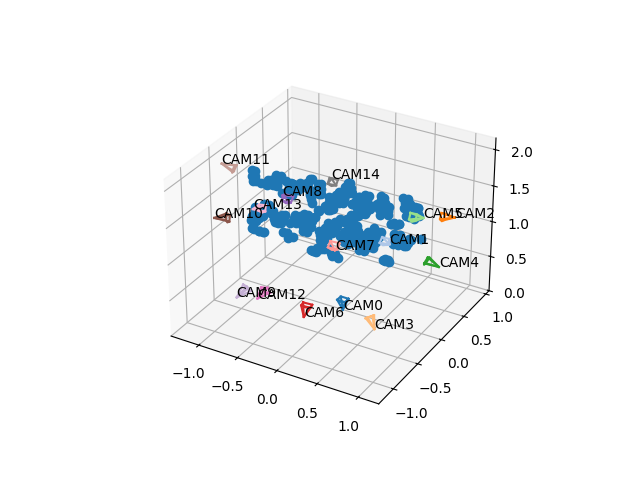

In [4]:
camera_params = pycalib.ba.encode_camera_params(
    np.tile(np.eye(3), (Nc, 1, 1)),
    np.tile(np.zeros((3,1)), (Nc, 1, 1)),
    np.tile(cameraMatrix, (Nc, 1, 1)),
    np.tile(distCoeffs, (Nc, 1)))
camera_params, points_3d = pycalib.bal.bal_recalib(camera_params, camera_indices, point_indices, points_2d)

pycalib.plot.plotCameras(camera_params, points_3d)
plt.show()

### 3-5: Bundle adjustment

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.5190e+07                                    6.25e+07    
       1              2         1.5820e+05      1.50e+07       1.61e+00       6.72e+06    
       2              3         7.5297e+02      1.57e+05       1.14e-01       1.01e+05    
       3              4         5.8206e+02      1.71e+02       4.52e-03       6.99e+01    
       4              5         5.8206e+02      3.00e-04       1.23e-05       1.85e+00    
`ftol` termination condition is satisfied.
Function evaluations 5, initial cost 1.5190e+07, final cost 5.8206e+02, first-order optimality 1.85e+00.
reprojection error (RMSE) = 0.840957568058072


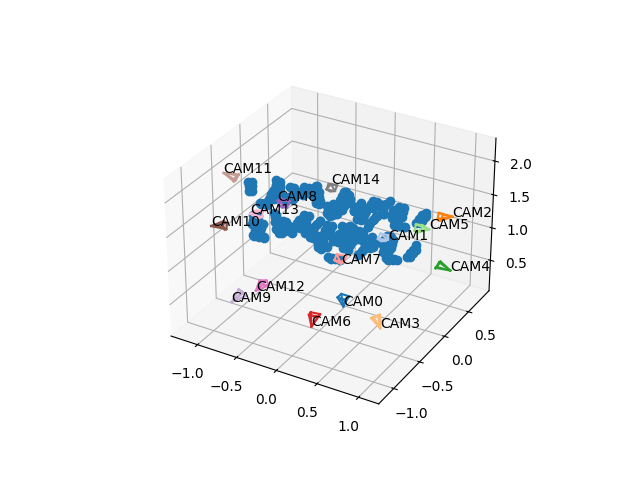

In [5]:
camera_params, points_3d, reproj, ret = pycalib.ba.bundle_adjustment(camera_params, points_3d, camera_indices, point_indices, points_2d, mask=MASK)

#print(ret)
print(f'reprojection error (RMSE) = {reproj}')
pycalib.plot.plotCameras(camera_params, points_3d)
plt.show()

### 3-6: Save as JSON

In [6]:
R, T, K, D = pycalib.ba.decode_camera_params(camera_params)
pycalib.util.save_calib(FILE_RESULT_BA, camera_matrix=K, dist_coeffs=D, rmat=R, tvec=T, reproj=reproj)